In [1]:
# Provides support for large, multi-dimensional arrays and matrices, as well as a wide range of mathematical functions
# We will be using this library to initialize our maze.
import numpy as np

# A 2D plotting library that enables users to create a wide variety of high-quality plots and visualizations.
# We will be using this library to display our maze in a visually appealing way.
import matplotlib.pyplot as plt

# A library that provides various functions for working with time-related operations. We will be using this library
# to give us time to look at how the agent is progressing through the maze
import time

import random

print("You have imported all the libraries.")

You have imported all the libraries.


In [50]:
class Maze:
    def __init__(self, maze_layout, start_position):
        # Initialize Maze object with the provided maze layout and start_position
        self.maze_layout = maze_layout
        self.explorable_cells = np.sum(self.maze_layout == 0) # Count the number of explorable cells in the maze
        self.maze_height = maze_layout.shape[0]-1 # Get the height of the maze (number of rows)
        self.maze_width = maze_layout.shape[1]-1  # Get the width of the maze (number of columns)
        self.start_position = start_position    # Set the start position in the maze as a tuple (x, y)
        
    def draw_maze(self, agent=None, start_position=None):
        print("Maximum cells to explore: ", self.explorable_cells)
        plt.imshow(self.maze_layout, cmap=plt.cm.binary, interpolation='nearest')
        if agent:
            plt.scatter(agent.y, agent.x, color='red', s=100, marker='o')
        elif start_position:
            plt.scatter(self.start_position[0],self.start_position[1], color='red', s=100, marker='o')
        plt.xticks([])
        plt.yticks([])
        plt.show()

def generate_maze(rows, cols, obs_prob=0.85):
        rows = int(rows / 2)
        cols = int(cols / 2)

        maze_layout = np.ones((rows * 2 + 1, cols * 2 + 1))

        x, y = (0, 0)

        stack = [(x, y)]
        while len(stack) > 0:
            x, y = stack[-1]

            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            random.shuffle(directions)

            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze_layout[2 * nx + 1, 2 * ny + 1] == 1:
                    maze_layout[2 * nx + 1, 2 * ny + 1] = 0
                    maze_layout[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                    stack.append((nx, ny))
                    break
            else:
                stack.pop()

        zero_indices = np.argwhere(maze_layout == 0)
        zero_coords = [tuple(index) for index in zero_indices]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # adds randomly crosses of free space.
        for z in zero_coords:
            if random.random() >= obs_prob:
                for dx, dy in directions:
                    nx, ny = z[0] + dx, z[1] + dy
                    maze_layout[nx, ny] = 0

        maze_layout[0, :] = 1
        maze_layout[-1, :] = 1
        maze_layout[:, 0] = 1
        maze_layout[:, -1] = 1

        # removes crosses (so agents wont be stuck).
        for i in range(maze_layout.shape[0]):
            for j in range(maze_layout.shape[1]):
                walls = []
                for d in directions:
                    neighbor_i = i + d[0]
                    neighbor_j = j + d[1]
                    # Check if neighbor is in bounds
                    if 0 <= neighbor_i < maze_layout.shape[0] and 0 <= neighbor_j < maze_layout.shape[1] and maze_layout[
                        (neighbor_i, neighbor_j)]:
                        walls.append((neighbor_i, neighbor_j))
                if len(walls) >= len(directions):
                    for coord in walls:
                        maze_layout[coord] = 0

        # re-adds the boundaries (after cross removed).
        maze_layout[0, :] = 1
        maze_layout[-1, :] = 1
        maze_layout[:, 0] = 1
        maze_layout[:, -1] = 1

        return maze_layout

Maximum cells to explore:  59


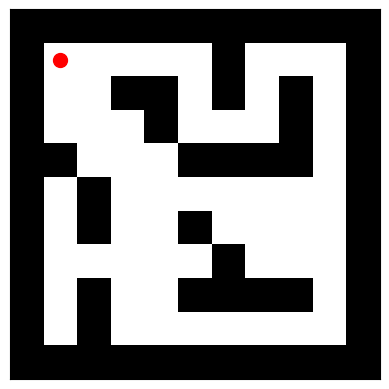

In [52]:
# Or generate one random maze
maze_layout = generate_maze(10, 10)
start_position = (1, 1)
# Create an instance of the maze and set the starting and ending positions
maze = Maze(maze_layout,start_position)
# Visualize the maze
maze.draw_maze(start_position=start_position)

In [74]:
# Actions the agent can take: Up, Down, Left, Right. Each action is represented as a tuple of two values: (row_change, column_change)
actions = [(-1, 0), # Up: Moving one step up, reducing the row index by 1
          (1, 0),   # Down: Moving on step down, increasing the row index by 1
          (0, -1),  # Left: Moving one step to the left, reducing the column index by 1
          (0, 1)]   # Right: Moving one step to the right, increasing the column index by 1

class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.8, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        # Initialize the Q-learning agent with a Q-table containing all zeros
        # where the rows represent states, columns represent actions, and the third dimension is for each action (Up, Down, Left, Right)
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) # 4 actions: Up, Down, Left, Right
        self.learning_rate = learning_rate          # Learning rate controls how much the agent updates its Q-values after each action
        self.discount_factor = discount_factor      # Discount factor determines the importance of future rewards in the agent's decisions
        self.exploration_start = exploration_start  # Exploration rate determines the likelihood of the agent taking a random action
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        # Calculate the current exploration rate using the given formula
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode): # State is tuple representing where agent is in maze (x, y)
        exploration_rate = self.get_exploration_rate(current_episode)
        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) # Choose a random action (index 0 to 3, representing Up, Down, Left, Right)
        else:
            return np.argmax(self.q_table[state]) # Choose the action with the highest Q-value for the given state

    def update_q_table(self, state, action, next_state, reward):
        # Find the best next action by selecting the action that maximizes the Q-value for the next state
        best_next_action = np.argmax(self.q_table[next_state])

        # Get the current Q-value for the current state and action
        current_q_value = self.q_table[state][action]

        # Q-value update using Q-learning formula
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Update the Q-table with the new Q-value for the current state and action
        self.q_table[state][action] = new_q_value


In [116]:
goal_reward = 10000 # the goal is to explore the whole maze 
wall_penalty = -10
step_penalty = -1

In [91]:
# This function simulates the agent's movements in the maze for a single episode.

def finish_episode(agent, maze, current_episode, train=True, maximum_steps=1000):
    # Initialize the agent's current state to the maze's start position
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    cells_explored = np.zeros((maze.maze_height, maze.maze_width))
    not_all_cells_explored = False

    # Continue until the episode is done
    while not is_done:
        # Get the agent's action for the current state using its Q-table
        action = agent.get_action(current_state, current_episode)

        # Compute the next state based on the chosen action
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Check if the next state is out of bounds or hitting a wall
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.maze_layout[next_state] == 1):  # Check if it's a wall
            reward = wall_penalty
            next_state = current_state  # Stay in place

        # Check if the agent explored all the cells:
        elif np.sum(cells_explored) == maze.explorable_cells:
            path.append(current_state)
            reward = goal_reward
            is_done = True
        # The agent takes a step but hasn't explored all the cells yet
        else:
            if cells_explored[next_state] == 0:
                cells_explored[next_state] = 1
            path.append(current_state)
            reward = step_penalty

        # Update the cumulative reward and step count for the episode
        episode_reward += reward
        episode_step += 1
        if episode_step >= maximum_steps:
            not_all_cells_explored = True
            break
        # Update the agent's Q-table if training is enabled
        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        # Move to the next state for the next iteration
        current_state = next_state
    cells_explored = np.sum(cells_explored)
    # Return the cumulative episode reward, total number of steps, and the agent's path during the simulation
    return episode_reward, episode_step, path, cells_explored, not_all_cells_explored

Learned Path:
(1, 1)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 4)-> (1, 5)-> (2, 5)-> (1, 5)-> (1, 4)-> (1, 3)-> (1, 2)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (2, 2)-> (3, 2)-> (2, 2)-> (3, 2)-> (3, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (2, 2)-> (1, 2)-> (1, 1)-> (1, 2)-> (2, 2)-> (2, 1)-> (2, 2)-> (1, 2)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (3, 1)-> (2, 1)-> (3, 1)-> (2, 1)-> (1, 1)-> (1, 2)-> (2, 2)-> (3, 2)-> (3, 3)-> (3, 2)-> (3, 3)-> (4, 3)-> (5, 3)-> (6, 3)-> (7, 3)-> (8, 3)-> (7, 3)-> (8, 3)-> (9, 3)-> (9, 4)-> (8, 4)-> (8, 3)-> (9, 3)-> (8, 3)-> (8, 4)-> (7, 4)-> (7, 3)-> (8, 3)-> (8, 4)-> (9, 4)-> (8, 4)-> (8, 3)-> (8, 4)-> (8, 3)-> (8, 4)-> (7, 4)-> (6, 4)-> (6, 3)-> (7, 3)-> (7, 2)-> (7, 3)-> (7, 2)-> (7, 3)-> (7, 2)-> (7, 1)-> (8, 1)-> (9, 1)-> (8, 1)-> (7, 1)-> (7, 2)-> (7, 1)-> (6, 1)-> (5, 1)-> (6, 1)-> (7, 1)-> (6, 1)-> (5, 1)-> (6, 1)-> (5, 1)-> (6, 1)-> (7, 1)-> (6, 1)-> (7, 1)-> (7, 2)-> (7, 3)-> (7, 2)-> (7, 3)-> (6, 3)-> (5, 3

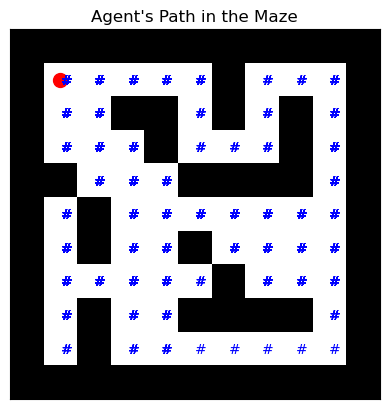

(2833, -12029)

In [114]:
# This function evaluates an agent's performance in the maze. The function simulates the agent's movements in the maze,
# updating its state, accumulating the rewards, and determining the end of the episode when the agent explores all the cells.
# The agent's learned path is then printed along with the total number of steps taken and the total reward obtained during the
# simulation. The function also visualizes the maze with the agent's path marked in blue for better visualization of the
# agent's trajectory.

def test_agent(agent, maze, num_episodes=1):
    # Simulate the agent's behavior in the maze for the specified number of episodes
    maximum_steps = maze.explorable_cells * 100 # Maximum steps allowed to explore the maze
    episode_reward, episode_step, path, cells_explored, not_all_cells_explored = finish_episode(agent, maze, num_episodes, train=False, maximum_steps=maximum_steps)
    
    
    # print("Learned Path:")
    # for row, col in path:
    #     print(f"({row}, {col})-> ", end='')
        
    if not_all_cells_explored:
        print("Failed to explore maze in ", maximum_steps, " steps.")
        print("Cells explored:", cells_explored)
        print("Number of steps:", episode_step)
        print(int(episode_step/cells_explored), " Steps per Cell Explored")
        print("Total reward:", episode_reward)
    else:
        # Print the learned path of the agent
        print("Learned Path:")
        for row, col in path:
            print(f"({row}, {col})-> ", end='')
        print("Maze fully explored!")
        print("Cells explored:", cells_explored)
        print("Number of steps:", episode_step)
        print(int(episode_step/cells_explored), " Steps per Cell Explored")
        print("Total reward:", episode_reward)
        
        # Clear the existing plot if any
        if plt.gcf().get_axes():
            plt.cla()
    
        # Visualize the maze
        plt.imshow(maze.maze_layout, cmap=plt.cm.binary, interpolation='nearest')
        plt.scatter(maze.start_position[0],maze.start_position[1], color='red', s=100, marker='o')
        plt.title("Agent's Path in the Maze")
        
        # Mark the agent's path with blue '#' symbols
        for position in path:
            if maze.maze_layout[position] == 1:
                print(f"Error! Path includes a wall at {position}")
            plt.text(position[1], position[0], "#", va='center', color='blue', fontsize=10) # Flip the row and column for plotting
    
        # Remove axis ticks and grid lines for a cleaner visualization
        plt.xticks([]), plt.yticks([])
        # plt.grid(color='black', linewidth=2)
        plt.show()

    return episode_step, episode_reward

agent = QLearningAgent(maze)
# Test the agent using the test_agent function
test_agent(agent, maze)

In [95]:
def train_agent(agent, maze, num_episodes=100):
    # Lists to store the data for plotting
    total_rewards = []
    total_steps = []
    total_cells_explored = []

    # Loop over the specified number of episodes
    for episode in range(num_episodes):
        episode_reward, episode_step, path, episode_cells_explored, not_all_cells_explored = finish_episode(agent, maze, episode, train=True)

        # Store the episode's cumulative reward and the number of steps taken in their respective lists
        total_rewards.append(episode_reward)
        total_steps.append(episode_step)
        total_cells_explored.append(episode_cells_explored)
    # Plotting the data after training is completed
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')

    average_reward = sum(total_rewards) / len(total_rewards)
    print(f"The average reward is: {average_reward}")

    plt.subplot(1, 2, 2)
    plt.plot(total_cells_explored)
    plt.xlabel('Episode')
    plt.ylabel('Cells Explored')
    plt.ylim(0, 100)
    plt.title('Cells Explored per Episode')

    average_cells_explored = sum(total_cells_explored) / len(total_cells_explored)
    print(f"The average cells explored are: {average_cells_explored}")

    plt.tight_layout()
    plt.show()


In [1]:
# Training the agent
train_agent(agent, maze, num_episodes=10000)

NameError: name 'train_agent' is not defined

Learned Path:
(1, 1)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 3)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 3)-> (1, 2)-> (2, 2)-> (2, 1)-> (1, 1)-> (2, 1)-> (2, 2)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 3)-> (1, 2)-> (2, 2)-> (3, 2)-> (2, 2)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 4)-> (1, 5)-> (2, 5)-> (3, 5)-> (3, 6)-> (3, 5)-> (3, 6)-> (3, 5)-> (2, 5)-> (1, 5)-> (2, 5)-> (1, 5)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 5)-> (1, 4)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (2, 2)-> (1, 2)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (3, 1)-> (3, 2)-> (3, 3)-> (4, 3)-> (5, 3)-> (6, 3)-> (7, 3)-> (7, 2)-> (7, 1)-> (7, 2)-> (7, 1)-> (8, 1)-> (9, 1)-> (8, 1)-> (7, 1)-> (7, 2)-> (7, 3)-> (6, 3)-> (6, 4)-> (5, 4)-> (5, 3)-> (4, 3)-> (3, 3)-> (3, 2)-> (3, 1)-> (2, 1)-> (2, 2)-> (1, 2)-> (1, 1)-> (2, 1)-> (2, 2)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (2, 2)-> (3, 2)-> (3, 1

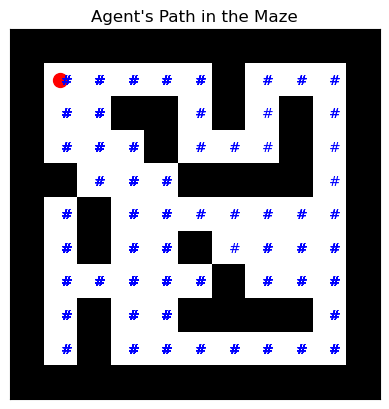

(1687, 2536)

In [123]:
# Testing the agent after training
test_agent(agent, maze, num_episodes=1)